In [115]:
import MySQLdb
import MySQLdb.cursors
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LinR
import numpy as np
import sys
import re
%matplotlib inline
import matplotlib as plt
from __future__ import division
from sklearn.decomposition import PCA

In [116]:
conn = MySQLdb.connect(
            user="root",
            passwd="",
            db="Player_Team_Data",
            cursorclass=MySQLdb.cursors.DictCursor)

In [117]:
player = 'dirk nowitzki'
cmd_Rk= 'SELECT Rk FROM NBA_player_data WHERE Player_Name IN (\'' + player + '\')  AND Year IN (\'2015\');'
df_Rk = pd.read_sql(cmd_Rk, con=conn) 

def get_fanduel(predict,avg,tru):
    fanduel_pre = predict[0]+predict[2]*1.2+predict[3]*1.5+predict[4]*2+predict[5]*2-predict[6]
    fanduel_avg = avg[0]+avg[2]*1.2+avg[3]*1.5+avg[4]*2+avg[5]*2-avg[6]
    fanduel_tru = tru[0]+tru[2]*1.2+tru[3]*1.5+tru[4]*2+tru[5]*2-tru[6]
    return fanduel_pre, fanduel_avg, fanduel_tru

def get_trend(fan_pre,fan_avg,fan_tru):
    
    if (fan_pre > fan_avg) and (fan_tru > fan_avg):
        val = 1
    elif (fan_pre < fan_avg) and (fan_tru < fan_avg):
        val = 1
    elif (fan_pre < fan_avg) and (fan_tru > fan_avg):
        val = 0
    elif (fan_pre > fan_avg) and (fan_tru < fan_avg):    
        val = 0
    else:
        val = 2
    return val

In [118]:
f_pre = []
f_avg = []
f_tru = []

for Rki in df_Rk.Rk:
    Rk = str(Rki)
    cmd_min_2015 = 'SELECT MP FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+';'   
    cmd_min_2014 = 'SELECT MP FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+';'   
    cmd_train_wo_mp_2015 = 'SELECT Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+';'
    cmd_train_wo_mp_2014 = 'SELECT Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+';'
    cmd_operate_mp = 'SELECT Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk = '+Rk+';'
    
    
    #separate
    cmd_train_2015 = 'SELECT MP,Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+';'
    cmd_train_2014 = 'SELECT MP,Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+';'
    cmd_operate = 'SELECT Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk = '+Rk+';'
    cmd_truth = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk = '+Rk+' ;'
    cmd_target_2015 = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+' ;'
    cmd_target_2014 = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+' ;'
    
    df_min_2015 = pd.read_sql(cmd_min_2015, con=conn) 
    df_min_2014 = pd.read_sql(cmd_min_2014, con=conn)
    df_train_wo_mp_2015 = pd.read_sql(cmd_train_wo_mp_2015, con=conn) 
    df_train_wo_mp_2014 = pd.read_sql(cmd_train_wo_mp_2014, con=conn)
    df_operate_mp = pd.read_sql(cmd_operate_mp, con=conn)
    
    # separate
    df_target_2015 = pd.read_sql(cmd_target_2015, con=conn) 
    df_target_2014 = pd.read_sql(cmd_target_2014, con=conn) 
    df_train_2015 = pd.read_sql(cmd_train_2015, con=conn) 
    df_train_2014 = pd.read_sql(cmd_train_2014, con=conn) 
    df_operate = pd.read_sql(cmd_operate, con=conn) 
    df_truth = pd.read_sql(cmd_truth, con=conn) 
    df_truth = df_truth.applymap(lambda x: float(x))
    
    df_min = pd.concat([df_min_2014, df_min_2015],ignore_index=True).applymap(lambda x: float(x))
    df_train_wo_mp = pd.concat([df_train_wo_mp_2014, df_train_wo_mp_2015],ignore_index=True).applymap(lambda x: float(x))
    
    df_inquire_mp = df_operate_mp.applymap(lambda x:float(x))
    df_train_plus_inquire_mp=pd.concat([df_train_wo_mp, df_inquire_mp])
    
   
    df_raw_mp = df_train_plus_inquire_mp.reindex()
    df_raw_scaled_mp = df_raw_mp.copy()
    df_raw_scaled_mp = df_raw_scaled_mp.applymap(lambda x: np.log(x))
    
    df_raw_transform_mp = df_raw_mp.copy()
    df_raw_scaled_mp = df_raw_scaled_mp.apply(lambda x:preprocessing.StandardScaler().fit(x).transform(x))
    df_raw_transform_mp = df_raw_transform_mp.apply(lambda x:preprocessing.StandardScaler().fit(x))

    pca_mp = PCA()
    pca_mp.fit(df_raw_scaled_mp)
    pca_mp.n_components=7
    train_reduced_mp = pca_mp.fit_transform(df_raw_scaled_mp)
    df_train_reduced_mp=pd.DataFrame(train_reduced_mp)
    
    df_evaluate_mp = df_train_reduced_mp.tail(1)
    df_train_scaled_mp = df_train_reduced_mp.iloc[:-1]
    
    MP = LinR()
    MP.fit(df_train_scaled_mp, df_min.MP)
    pMP = float(MP.predict(df_evaluate_mp))
    
    
    
    #separate
    df_target=pd.concat([df_target_2014, df_target_2015],ignore_index=True)
    df_train=pd.concat([df_train_2014, df_train_2015],ignore_index=True)
    df_target = df_target.applymap(lambda x:float(x))
    df_train = df_train.applymap(lambda x:float(x))
    df_target_2015 = df_target_2015.applymap(lambda x: float(x))
    df_operate['MP']=pMP
    df_inquire = df_operate.applymap(lambda x:float(x))
    df_train_plus_inquire=pd.concat([df_train, df_inquire])
    df_raw = df_train_plus_inquire.reindex()
    df_raw_scaled = df_raw.copy()
    df_raw_scaled = df_raw_scaled.applymap(lambda x: np.log(x))
    df_raw_transform = df_raw.copy()

    df_raw_scaled = df_raw_scaled.apply(lambda x:preprocessing.StandardScaler().fit(x).transform(x))
    df_raw_transform = df_raw_transform.apply(lambda x:preprocessing.StandardScaler().fit(x))

    pca = PCA()
    pca.fit(df_raw_scaled)
    pca.n_components=4
    train_reduced = pca.fit_transform(df_raw_scaled)
    df_train_reduced=pd.DataFrame(train_reduced)
    df_evaluate = df_train_reduced.tail(1)
    df_train_scaled = df_train_reduced.iloc[:-1]
    
    


#     rf = RandomForestRegressor(n_estimators=100)
#     rf.fit(df_train_scaled, df_target)
#     predictions = rf.predict(df_evaluate).round()[0]
    
    PTS = LinR()
    PTS.fit(df_train_scaled, df_target.PTS)
    pPTS = PTS.predict(df_evaluate)
    REB = LinR()
    REB.fit(df_train_scaled, df_target.TRB)
    pREB = REB.predict(df_evaluate)
    AST = LinR()
    AST.fit(df_train_scaled, df_target.AST)
    pAST = AST.predict(df_evaluate)
    TP = LinR()
    TP.fit(df_train_scaled, df_target['3P'])
    pTP = TP.predict(df_evaluate)
    STL = LinR()
    STL.fit(df_train_scaled, df_target.STL)
    pSTL = STL.predict(df_evaluate)
    BLK = LinR()
    BLK.fit(df_train_scaled, df_target.BLK)
    pBLK = BLK.predict(df_evaluate)
    TOV = LinR()
    TOV.fit(df_train_scaled, df_target.TOV)
    pTOV = TOV.predict(df_evaluate)
    
    predictions = np.asarray([pPTS,pTP,pREB,pAST,pSTL,pBLK,pTOV])
    
    if int(Rk) < 20:
        average_stats=df_target.mean().round()   
    elif int(Rk) >= 20:
        average_stats=df_target_2015.mean().round()
              
    average_stats=np.asarray(average_stats)
    true_stats = np.asarray(df_truth)[0]
    fanduel_pre, fanduel_avg, fanduel_tru = get_fanduel(predictions,average_stats,true_stats)
    f_pre.append(fanduel_pre)
    f_avg.append(fanduel_avg)
    f_tru.append(fanduel_tru)

In [119]:
score =[]
for i,f in enumerate(f_pre):
    s=get_trend(f,f_avg[i],f_tru[i])
    score.append(s)


<Container object of 3 artists>

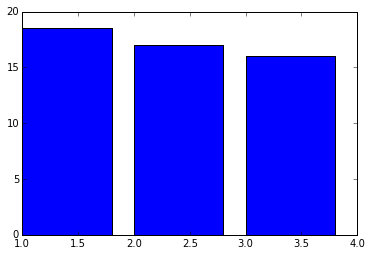

In [120]:
x = [1,2,3]
plt.pyplot.bar( x,[predictions[0],average_stats[0] , true_stats[0]])

In [121]:
a = [x for x in score if x != 2]

In [122]:
a.count(1)/len(a)



0.4805194805194805

In [123]:
def get_min(x):
    match = re.search('(\w+):(\w+)', x)
    minute = float(match.group(1))
    second = float(match.group(2))/60
    timet = minute+second
    return timet

In [124]:
df_minx = df_min.applymap(lambda x: np.std)
df_minx

,MP
0,<function std at 0x1048efed8>
1,<function std at 0x1048efed8>
2,<function std at 0x1048efed8>
3,<function std at 0x1048efed8>
4,<function std at 0x1048efed8>
5,<function std at 0x1048efed8>
6,<function std at 0x1048efed8>
7,<function std at 0x1048efed8>
8,<function std at 0x1048efed8>
9,<function std at 0x1048efed8>


In [125]:
df_minx.std()

Series([], dtype: float64)